# Generative adversarial networks



Oбучим GAN генерировать лица людей

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATA_DIR = '/kaggle/input/faces-dataset-small/'

## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory)

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)])
    )
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [7]:
train_dl = get_dataloader(image_size, batch_size)

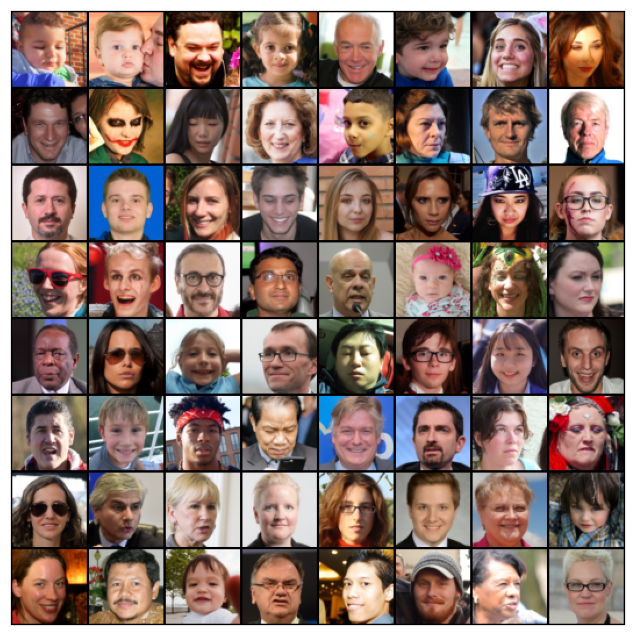

In [8]:
show_batch(train_dl)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


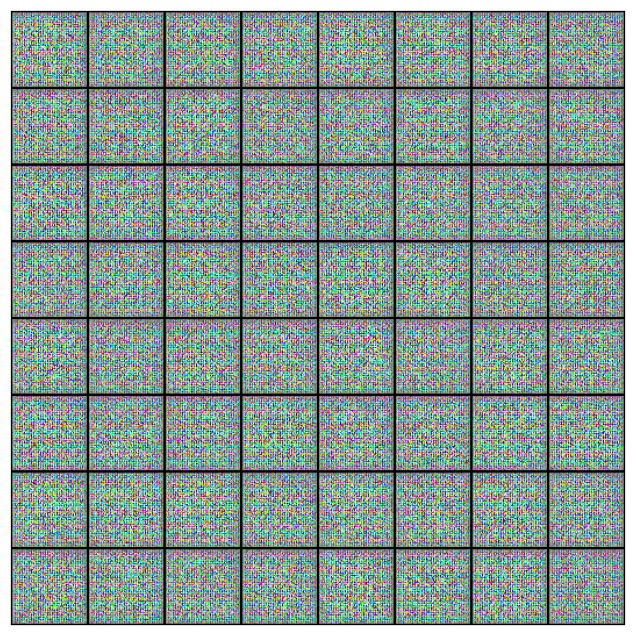

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [15]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [16]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [17]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0001
epochs = 40

In [18]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 4.1348, loss_d: 0.4027, real_score: 0.8621, fake_score: 0.1871


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 7.0873, loss_d: 0.1157, real_score: 0.9512, fake_score: 0.0541


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 7.7096, loss_d: 0.0719, real_score: 0.9677, fake_score: 0.0330


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 9.2479, loss_d: 0.0506, real_score: 0.9774, fake_score: 0.0246


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 14.0874, loss_d: 0.0794, real_score: 0.9796, fake_score: 0.0429


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 14.2415, loss_d: 0.0574, real_score: 0.9707, fake_score: 0.0199


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 13.3313, loss_d: 0.0901, real_score: 0.9727, fake_score: 0.0383


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 13.0977, loss_d: 0.0887, real_score: 0.9638, fake_score: 0.0342


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 11.2564, loss_d: 0.0838, real_score: 0.9659, fake_score: 0.0369


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 10.4636, loss_d: 0.4885, real_score: 0.8926, fake_score: 0.1146


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 5.6425, loss_d: 0.5220, real_score: 0.8147, fake_score: 0.1529


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.9038, loss_d: 0.3152, real_score: 0.8672, fake_score: 0.1179


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 5.4568, loss_d: 0.2662, real_score: 0.8887, fake_score: 0.0907


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 5.6135, loss_d: 0.1835, real_score: 0.9219, fake_score: 0.0715


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 5.5271, loss_d: 0.2219, real_score: 0.9064, fake_score: 0.0806


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.7056, loss_d: 0.2423, real_score: 0.9016, fake_score: 0.0937


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 5.6682, loss_d: 0.3016, real_score: 0.8872, fake_score: 0.1091


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.8971, loss_d: 0.2409, real_score: 0.9008, fake_score: 0.0882


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 5.2134, loss_d: 0.1207, real_score: 0.9448, fake_score: 0.0528


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 5.9518, loss_d: 0.3952, real_score: 0.8850, fake_score: 0.0979


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.8176, loss_d: 0.2375, real_score: 0.9046, fake_score: 0.1004


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 5.6723, loss_d: 0.2160, real_score: 0.9149, fake_score: 0.0802


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 6.6179, loss_d: 0.5221, real_score: 0.8642, fake_score: 0.1271


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 5.4196, loss_d: 0.2057, real_score: 0.9122, fake_score: 0.0854


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 4.7976, loss_d: 0.2199, real_score: 0.9124, fake_score: 0.0868


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 5.3410, loss_d: 0.4284, real_score: 0.8759, fake_score: 0.1198


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 5.1392, loss_d: 0.2173, real_score: 0.9108, fake_score: 0.0889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.9926, loss_d: 0.1713, real_score: 0.9304, fake_score: 0.0727


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 4.8569, loss_d: 0.2416, real_score: 0.8994, fake_score: 0.0957


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 4.9173, loss_d: 0.3792, real_score: 0.8901, fake_score: 0.1114


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 4.5447, loss_d: 0.2590, real_score: 0.8966, fake_score: 0.1048


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 5.8790, loss_d: 0.4103, real_score: 0.8766, fake_score: 0.1208


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.8817, loss_d: 0.2473, real_score: 0.8979, fake_score: 0.0980


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 4.7347, loss_d: 0.1548, real_score: 0.9300, fake_score: 0.0684


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.7407, loss_d: 0.1933, real_score: 0.9170, fake_score: 0.0830


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 5.0202, loss_d: 0.4689, real_score: 0.8746, fake_score: 0.1201


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.5789, loss_d: 0.2491, real_score: 0.8936, fake_score: 0.0968


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 4.8116, loss_d: 0.1939, real_score: 0.9202, fake_score: 0.0847


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 5.3356, loss_d: 0.2774, real_score: 0.8960, fake_score: 0.1039


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 5.0607, loss_d: 0.2923, real_score: 0.8898, fake_score: 0.1068


In [19]:
losses_g, losses_d, real_scores, fake_scores = history

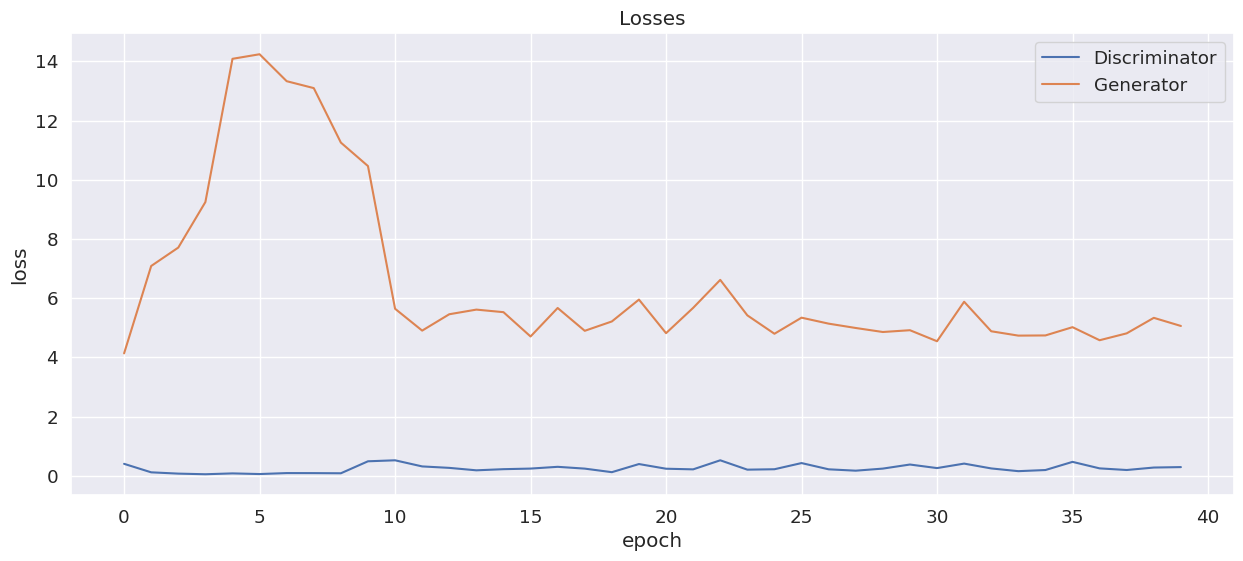

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений, сгенерированные нашим генератором

In [21]:
n_images = 9

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

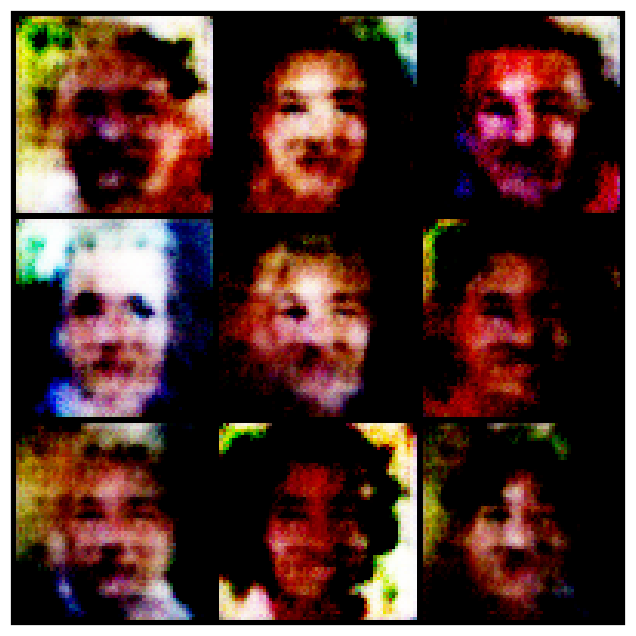

In [22]:
def show_images(generated):
    # TODO: show generated images
    n = int(fake_images.shape[0] ** 0.5)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=n).permute(1, 2, 0))


show_images(fake_images)